# Produce two and three knock-downs recommendations

This notebook explains how to produce recommendations for knockdown of two and three genes for the CRISPRi project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl

## Input and output

Required files to run this notebook:

- ``Sample name, CRISPRi target gene, Uniprot ID.xlsx`` : file with mapping from Uniprot protein IDs to PP_XXXX gene numbers

Files generated by running this notebook:

- ``CRISPRi_double_targets.csv`` : file with double knock-down recommendations
- ``CRISPRi_triple_targets.csv`` : file with triple knock-down recommendations

## Setup

### Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### User parameters

In [2]:
user_params = {
    'output_dir'  : './results',
    'protein_map' : './data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
    'double_targets_file': f'./data/CRISPRi_double_targets.csv',
    'triple_targets_file': f'./data/CRISPRi_triple_targets.csv',
    'run_list' : f'./data/David Carruthers sample injection order.xlsx'
}

In [3]:
ls

check_original_prot_map.ipynb      get_Pputida_uniprot.ipynb
choose_targets_sandbox.ipynb       get_Pputida_unreviewed_uniprot.ipynb
data/                              results/
DBTL1Recs4David.ipynb              test_normalize_checkpivot.ipynb
DBTL1Recs4David_local.ipynb        test_normalize.ipynb
DBTL1Recs4David_plotupdates.ipynb


### Useful functions

In [4]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

In [5]:
def find_library_stats(df):
    """Find mean, std and quartiles of the target transcription level from the whole library excluding the target strain"""
    
    stat_names = ['Library_mean', 'Library_std', 'Library_Q1', 'Library_Q3']
    for n in stat_names:
        df.loc[n] = None
        df.loc[n].astype('float64')

    no_data =[]
    for target in df['Target'].dropna():
        if target in df.columns:
            # Exclude the target strain from the mean
            ind = df.index[df['Target']==target].tolist()       
            ind.extend(stat_names)

            mean = df.drop(index=ind)[target].mean()
            df.loc['Library_mean', target] = mean

            std = df.drop(index=ind)[target].std()
            df.loc['Library_std', target] = std

            q1 = df.drop(index=ind)[target].quantile(.25)
            q3 = df.drop(index=ind)[target].quantile(.75)
            df.loc['Library_Q1', target] = q1
            df.loc['Library_Q3', target] = q3
        else:
            #no_data.append((df_targets[df_targets.loc[:,"Target"]==target].index.tolist(),target))
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
            
        
    return df

In [6]:
def find_fold_changes(df):
    """Find fold changes of the transcription in the targeted strain vs library"""
    
    col_names = [
        'Target:Control', 
        'Target:Library_mean', 
        'Target:Library_Q1', 
        'Target:Library_Q3',
        'Z-score'
    ]
    df[col_names] = None

    no_data = []
    for target in df['Target'].dropna():
        if target in df.columns:
            ind = df.index[df['Target']==target][0]

            df.loc[
                ind, 'Target:Control'
            ] = df.loc[ind, target] / df.loc[control_strain, target]

            mean = df.loc['Library_mean'][target]
            std = df.loc['Library_std'][target]

            df.loc[
                ind, 'Target:Library_mean'
            ] = df.loc[ind, target] / mean

            df.loc[
                ind, 'Target:Library_Q1'
            ] = df.loc[ind, target] / df.loc['Library_Q1'][target]
            df.loc[
                ind, 'Target:Library_Q3'
            ] = df.loc[ind, target] / df.loc['Library_Q3'][target]

            df.loc[
                ind, 'Z-score'
            ] = (df.loc[ind, target] - mean) / std
        else:
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
    
    return df
    

## Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [7]:
study_slug_1 = 'crispri-automation-for-isoprenol-production-in-p-p'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'

We try connecting to the server with our login and password:

In [35]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········
Password for pckinnunen:  ········
Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [9]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

100%|██████████| 1182270/1182270 [01:01<00:00, 19271.42it/s]


There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [10]:
df['Protocol'].unique()

array(['Biolector', 'GC-FID', 'Global Proteomics'], dtype=object)

## Preprocess and inspect data

### Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [11]:
df['Protocol']=='Biolector'

0           True
1           True
2           True
3           True
4           True
           ...  
1182265    False
1182266    False
1182267    False
1182268    False
1182269    False
Name: Protocol, Length: 1182270, dtype: bool

In [12]:
df2 = df.loc[df['Protocol']!='Biolector']

And we still have over a million entries of data:

In [13]:
df2.shape

(1033140, 15)

Let's just keep the basic data types:

In [14]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [15]:
line_desc = df2['Line Description'].unique()
len(line_desc), line_desc

(420,
 array(['BL1A2_IY1586', 'BL1A3_IY1587', 'BL1A4_IY1588', 'BL1A5_IY1589',
        'BL1A6_IY1590', 'BL1A7_IY1591', 'BL1A8_IY1592', 'BL1B2_IY1586',
        'BL1B3_IY1587', 'BL1B4_IY1588', 'BL1B5_IY1589', 'BL1B6_IY1590',
        'BL1B7_IY1591', 'BL1B8_IY1592', 'BL1C2_IY1586', 'BL1C3_IY1587',
        'BL1C4_IY1588', 'BL1C5_IY1589', 'BL1C6_IY1590', 'BL1C7_IY1591',
        'BL1C8_IY1592', 'BL1D1_IY1593', 'BL1D2_IY1594', 'BL1D3_IY1595',
        'BL1D4_IY1596', 'BL1D5_IY1597', 'BL1D6_IY1452_pIY1081',
        '**BL1D7_IY1655', '**BL1D8_IY1656', '**BL1E1_IY1593',
        '**BL1E2_IY1594', '**BL1E3_IY1595', 'BL1E4_IY1596', 'BL1E5_IY1597',
        'BL1E6_IY1452_pIY1081', 'BL1E7_IY1655', 'BL1E8_IY1656',
        'BL1F1_IY1593', 'BL1F2_IY1594', 'BL1F3_IY1595', 'BL1F4_IY1596',
        'BL1F5_IY1597', 'BL1F6_IY1452_pIY1081', 'BL1F7_IY1655',
        'BL1F8_IY1656', 'BL2A2_IY1452_pIY1079', 'BL2A3_IY1452_pIY1080',
        'BL2A4_IY1657', 'BL2A5_IY1658', 'BL2A6_IY1659', 'BL2A7_IY1660',
        'BL2A8_I

In [16]:
line_name = df2['Line Name'].unique()
len(line_name), line_name

(420,
 array(['PP_4549-R1', 'PP_4550-R1', 'PP_0368-R1', 'PP_2136-R1',
        'PP_0774-R1', 'PP_0362-R1', 'PP_0437-R1', 'PP_4549-R2',
        'PP_4550-R2', 'PP_0368-R2', 'PP_2136-R2', 'PP_0774-R2',
        'PP_0362-R2', 'PP_0437-R2', 'PP_4549-R3', 'PP_4550-R3',
        'PP_0368-R3', 'PP_2136-R3', 'PP_0774-R3', 'PP_0362-R3',
        'PP_0437-R3', 'PP_2589-R1', 'PP_3744-R1', 'PP_4194_NT2-R1',
        'PP_4194_NT3-R1', 'PP_1607_NT1-R1', 'PP_1607_NT4-R1',
        'PP_1607_NT1_xylS_Pm-R1', 'PP_1607_NT2_xylS_Pm-R1', 'PP_2589-R2',
        'PP_3744-R2', 'PP_4194_NT2-R2', 'PP_4194_NT3-R2', 'PP_1607_NT1-R2',
        'PP_1607_NT4-R2', 'PP_1607_NT1_xylS_Pm-R2',
        'PP_1607_NT2_xylS_Pm-R2', 'PP_2589-R3', 'PP_3744-R3',
        'PP_4194_NT2-R3', 'PP_4194_NT3-R3', 'PP_1607_NT1-R3',
        'PP_1607_NT4-R3', 'PP_1607_NT1_xylS_Pm-R3',
        'PP_1607_NT2_xylS_Pm-R3', 'PP_1607_NT2-R1', 'PP_1607_NT3-R1',
        'PP_1607_NT3_xylS_Pm-R1', 'PP_1607_NT4_xylS_Pm-R1', 'PP_1444-R1',
        'PP_0338-R1', 

In [17]:
df2['Formal Type'].unique()

array(['cid:12988', 'sp|O85207|PHAG_PSEPK Phag',
       'sp|P00552|KKA2_KLEPN Neo', ..., 'sp|Q88RM6|Q88RM6_PSEPK Pp_0103',
       'sp|Q88RS8|Q88RS8_PSEPK Pp_0051', 'sp|Q88RV6|Q88RV6_PSEPK Pp_0023'],
      dtype=object)

In [18]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

In [19]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

array(['3-METHYL-3-BUTEN-1-OL'], dtype=object)

In [20]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02
...,...,...,...,...,...,...
1182265,PP_5416-R2,BL10B5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.051687e+06
1182266,PP_5416-R3,BL10C5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,9.921411e+05
1182267,PP_5420-R1,BL10A4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,5.949145e+05
1182268,PP_5420-R2,BL10B4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,3.865737e+05


In [21]:
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588


## Normalize based on sample run time

1. Check to make sure each entry in df2['Line Name'] matches an entry in the order spreadsheet
2. Pull out controls from each day
3. Get rid of proteins missing from controls
4. Normalize each run by control mean
5. Compare the distributions of normalized and unnormalized proteins


### 1. Check correspondence between lists of line names.

Import order of runs.

In [22]:
df_order = pd.read_excel(user_params['run_list'])
df_order.head()
#make a sample->day dictionary
batch_day_dict = dict(df_order.values)

Check that sample names match between EDD and spreadsheet

In [23]:
unique_sample_names_order = df_order['Sample Name in order injected'].unique().sort()
unique_sample_names_df2 = df2['Line Name'].unique().sort()
print(f'Sorted, unique names are identical: {"Yes" if unique_sample_names_df2 == unique_sample_names_order else "No"}')
assert unique_sample_names_df2 == unique_sample_names_order, "ERROR: sample names don't match in spreadsheets."

Sorted, unique names are identical: Yes


### 2. Pull out controls and look at distributions of proteomics

We find the control strains by looking for the 'ontrol' string in the line name (using instead of 'Control' or 'control' to avoid capitalization issues), and we add the information as a new column:

In [24]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(find_control)
df_control = df2[df2['Control']].copy()

Find day each experiment was conducted and add to dataframe.

In [25]:
find_expt_day = lambda x: batch_day_dict[x]
df_control['Batch number'] = df_control['Line Name'].apply(find_expt_day)

Print the day for each control - they aren't uniformly distributed.

In [26]:
for ii in range(1,4):
    print(f'Controls on day {ii}: {df_control[df_control["Batch number"] == ii]["Line Name"].unique()}')

Controls on day 1: ['Control-R1' 'Control-R2' 'Control-R3' 'Control-R4' 'Control-R5'
 'Control-R6' 'Control-R7']
Controls on day 2: ['Control-R8' 'Control-R9' 'Control-R10' 'Control-R11' 'Control-R12'
 'Control-R13' 'Control-R14']
Controls on day 3: ['Control-R15' 'Control-R16' 'Control-R17' 'Control-R18']


### 3. Check for proteins missing from each day and drop them

Check how many different analytes are measured in controls.

In [42]:
print(f'There are {len(df_control["Measurement Type"].unique())} unique analytes in the control dataframe')

There are 2005 unique analytes in the control dataframe


Create pivot table based on batch number. 

In [43]:
cntrl_pivot_by_measurement = pd.pivot_table(df_control, values = 'Value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)
print(f'pivot by measurement size is: {cntrl_pivot_by_measurement.shape}')
measurement_matrix = cntrl_pivot_by_measurement.values

pivot by measurement size is: (2004, 3)


Check for missing and zero measurements in control runs. 

In [44]:
# any_measurement_missing = np.any(measurement_matrix == 'missing', 1)
# any_measurement_zero = np.any(measurement_matrix == 0, 1)
# print(f'There are {len(any_measurement_missing)} different measurement types in control pivot table.\n' , 
#       f'Of these, {sum(any_measurement_missing)} are missing on at least one day and \n', 
#       f'{sum(any_measurement_zero)} are zero on one day.')

/tmp/ipykernel_1121819/2498372543.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  any_measurement_missing = np.any(measurement_matrix == 'missing', 1)


AxisError: axis 1 is out of bounds for array of dimension 0

Add batch number to dataframe and make a copy.

In [45]:
df2['Batch number'] = df2['Line Name'].apply(find_expt_day)
df_norm = df2.copy()


Get measurement types that have all their control values. 

In [46]:
cntrl_pivot_by_measurement_exist = cntrl_pivot_by_measurement.dropna() 
list_of_control_measurements = cntrl_pivot_by_measurement_exist.index.values.tolist()
check_norm_exist = lambda x: 1 if x in list_of_control_measurements else 0
df_norm['can_normalize'] = df_norm['Measurement Type'].apply(check_norm_exist)

Drop measurements that can't be normalized. 

In [47]:
df_norm = df_norm[df_norm['can_normalize'] == 1]
df_norm.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,False,1,1
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,False,1,1
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,False,1,1
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,False,1,1
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,False,1,1


### 4. Normalize each run to the mean of that day's controls

Need to divide each measurement the correct batch control mean. Create column for holding the control mean and fill it in with lambda function.

In [48]:
df_norm['control_val'] = np.nan
#Iterate through batch numbers [1,2,3]
for ii in range(1,4):
    add_correct_normalization_value = lambda x: cntrl_pivot_by_measurement_exist[ii][x]
    df_norm.loc[df_norm['Batch number']== ii, 'control_val'] = df_norm[df_norm['Batch number']== ii]['Measurement Type'].apply(add_correct_normalization_value)

Add column to dataframe and fill it with normalized values. Don't normalize isoprenol.

In [49]:
df_norm['norm_value'] = np.nan
df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'norm_value'] = df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'Value']/df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'control_val']
df_norm.loc[df_norm['Measurement Type'] == '3-METHYL-3-BUTEN-1-OL', 'norm_value'] = df_norm.loc[df_norm['Measurement Type'] == '3-METHYL-3-BUTEN-1-OL', 'Value']
df_norm.head()


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,False,1,1,246.680643,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,False,1,1,246.680643,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,False,1,1,246.680643,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,False,1,1,246.680643,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,False,1,1,246.680643,215.1588


In [50]:
df_norm

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02,False,1,1,2.466806e+02,298.960400
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02,False,1,1,2.466806e+02,167.397500
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02,False,1,1,2.466806e+02,340.571400
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02,False,1,1,2.466806e+02,348.509700
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02,False,1,1,2.466806e+02,215.158800
...,...,...,...,...,...,...,...,...,...,...,...
1182265,PP_5416-R2,BL10B5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.051687e+06,False,3,1,1.503599e+06,0.699447
1182266,PP_5416-R3,BL10C5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,9.921411e+05,False,3,1,1.503599e+06,0.659844
1182267,PP_5420-R1,BL10A4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,5.949145e+05,False,3,1,1.503599e+06,0.395660
1182268,PP_5420-R2,BL10B4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,3.865737e+05,False,3,1,1.503599e+06,0.257099


#Want to look at normalization for different Measurement types, by taking the mean of all batch numbers for samples where Control == True

In [51]:
df_norm = df_norm[df_norm['Protocol'] == 'Global Proteomics']

In [52]:
cntrl_pivot_by_measurement_exist

Batch number,1,2,3
Measurement Type,,,
"1,6-anhydro-N-acetylmuramyl-L-alanine amidase",6.208115e+05,2.423324e+05,1.390554e+05
1-(5-phosphoribosyl)-5-[(5-phosphoribosylamino)methylideneamino] imidazole-4-carboxamide isomerase,1.615455e+07,1.409482e+07,1.065399e+07
1-deoxy-D-xylulose 5-phosphate reductoisomerase,1.360668e+06,1.272942e+06,6.328243e+05
1-deoxy-D-xylulose-5-phosphate synthase,6.763795e+06,6.899957e+06,3.815104e+06
"2,3,4,5-tetrahydropyridine-2,6-dicarboxylate N-succinyltransferase",2.086218e+07,1.893284e+07,1.215490e+07
...,...,...,...
tRNA uridine(34) hydroxylase,6.811182e+05,3.639142e+05,6.878404e+04
tRNA-cytidine(32) 2-sulfurtransferase,1.260755e+06,7.310560e+05,2.597702e+05
tRNA-dihydrouridine(20/20a) synthase,1.032816e+06,8.057458e+05,3.272786e+05


In [65]:
for ii in cntrl_pivot_by_measurement_exist.index[:50]:
    print(ii)
    for bb in cntrl_pivot_by_measurement_exist.columns:
        control_vals_from_dataframe = df_norm[(df_norm['Measurement Type'] == ii) & (df_norm['Batch number'] == bb) & (df_norm['Control'])]
        print(f'delta = {np.mean(control_vals_from_dataframe["Value"]) - cntrl_pivot_by_measurement_exist[bb][ii]}')

1,6-anhydro-N-acetylmuramyl-L-alanine amidase
delta = 0.0
delta = 0.0
delta = 0.0
1-(5-phosphoribosyl)-5-[(5-phosphoribosylamino)methylideneamino] imidazole-4-carboxamide isomerase
delta = 0.0
delta = 1.862645149230957e-09
delta = 0.0
1-deoxy-D-xylulose 5-phosphate reductoisomerase
delta = 0.0
delta = 0.0
delta = 0.0
1-deoxy-D-xylulose-5-phosphate synthase
delta = -1.862645149230957e-09
delta = 9.313225746154785e-10
delta = -4.656612873077393e-10
2,3,4,5-tetrahydropyridine-2,6-dicarboxylate N-succinyltransferase
delta = 3.725290298461914e-09
delta = 3.725290298461914e-09
delta = 0.0
2,3-bisphosphoglycerate-independent phosphoglycerate mutase
delta = 0.0
delta = 0.0
delta = 9.313225746154785e-10
2,4-dienoyl-CoA reductase
delta = 0.0
delta = 5.820766091346741e-11
delta = 0.0
2,5-diketo-D-gluconate reductase
delta = 2.9103830456733704e-11
delta = 0.0
delta = 0.0
2-C-methyl-D-erythritol 2,4-cyclodiphosphate synthase
delta = 0.0
delta = 0.0
delta = -2.9103830456733704e-11
2-C-methyl-D-eryth

### 5. Visualize results

#### Plot raw and mean data for Control measurements:

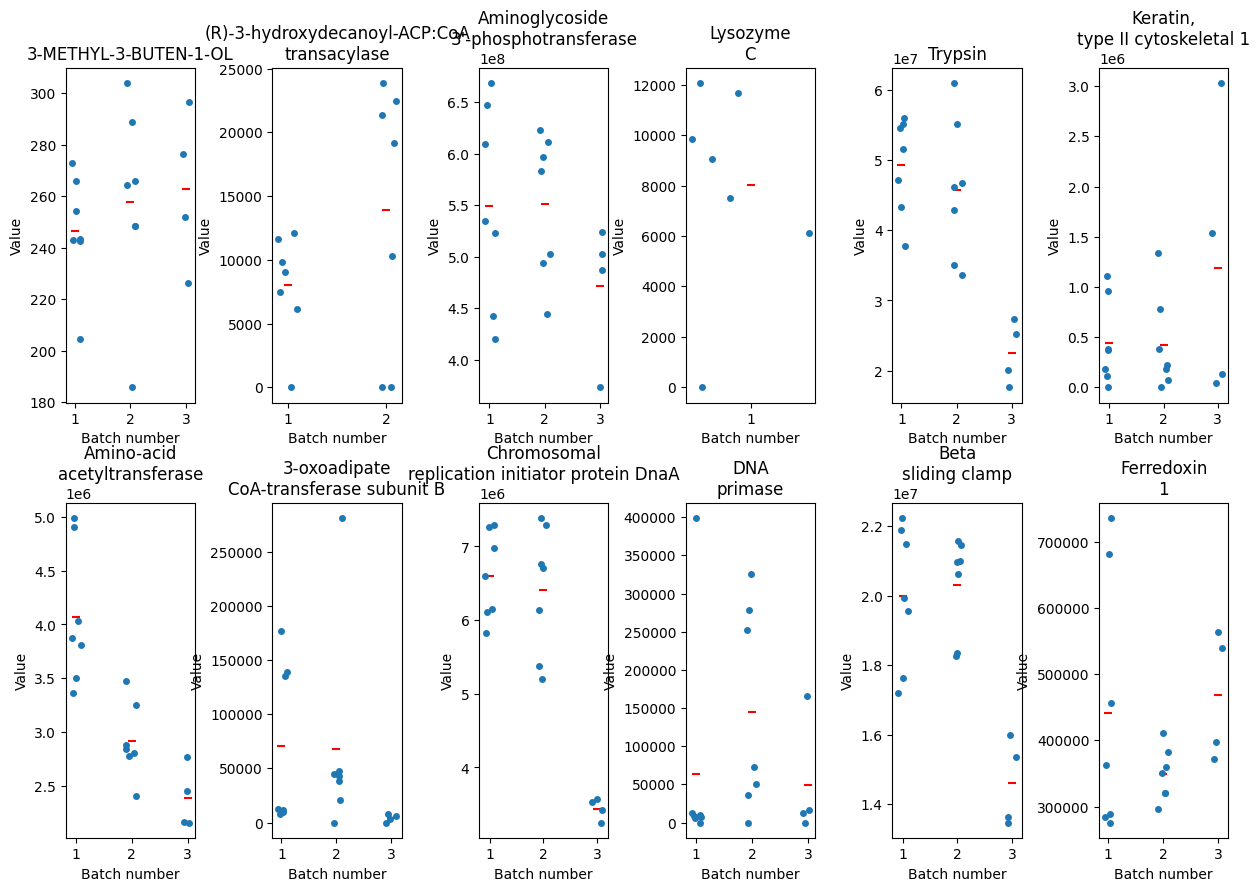

In [35]:
def compare_swarm(df, measurement_type, batches, ax = None, to_plot = 'Value'):
    if ax is None:
        fig, ax = plt.subplots(figsize = (len(batches), 5))
    df = df[df['Batch number'].isin(batches)]
    sns.stripplot(df[df['Measurement Type'] == measurement_type], x = 'Batch number', y = to_plot)
    
    #Add mean as red dot
    mean_vals = [np.mean(df[(df['Measurement Type'] == measurement_type) & (df['Batch number'] == batch_num)][to_plot]) for batch_num in batches]
                         
    _ = [ax.scatter(i, mean_vals[i], color = 'red', marker = '_') for i in range(len(batches))]
    plt.title(measurement_type)

def compare_swarm_multi(df, measurement_type, batches, to_plot = 'Value'):
    n_measures = len(measurement_type)
    fig = plt.figure(figsize=(15, 5*np.ceil(len(measurement_type)/6)))
    fig.subplots_adjust(hspace=0.3, wspace=0.6)
    #fig.suptitle('Comparing batches')
    
    for ii, m in enumerate(measurement_type):
        ax = fig.add_subplot(int(np.ceil(len(measurement_type)/6)), 6, (ii+1))
        compare_swarm(df, m, batches, ax, to_plot = to_plot)
        ax.set_title(m.replace(' ', '\n', 1))

target_list_all = df_control['Measurement Type'].unique().tolist()
compare_swarm_multi(df_control, target_list_all[:12], [1,2,3])

#### Plot differences b/w measurements on each day
Calculating $\Delta$(counts) for (day 3) - (day 1) should skew negative for unnormalized data, but should go away with normalization.

Create function to plot the distribution of differences between days. 

In [36]:
def plot_distribution_of_differences(meas_pivot, comparisons, labels):
    """
    Take a pivot table of measurements in and plot distributions of comparisons between days.
    """
    n_comparisons = len(comparisons)
    fig, ax = plt.subplots(nrows = 1, ncols = n_comparisons)
    for ii in range(n_comparisons):
        dif_current = meas_pivot[comparisons[ii][0]] - meas_pivot[comparisons[ii][1]]
        sns.histplot(dif_current, ax = ax[ii])
        ax[ii].set_xlabel(labels[ii])
    return fig, ax       

Make pivot tables for normalized an unnormalized data and set up labels. 

In [37]:
cntrl_pivot_by_measurement_nonnorm = pd.pivot_table(df_norm, values = 'Value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)
cntrl_pivot_by_measurement_norm = pd.pivot_table(df_norm, values = 'norm_value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)
dif_to_plot = [[3, 1],
               [2, 1]]
dif_labels = ['day 3 - day 1',
              'day 2 - day 1']

Make plots to show the distribution of differences. 

[(-10000000.0, 10000000.0), (-10000000.0, 10000000.0)]

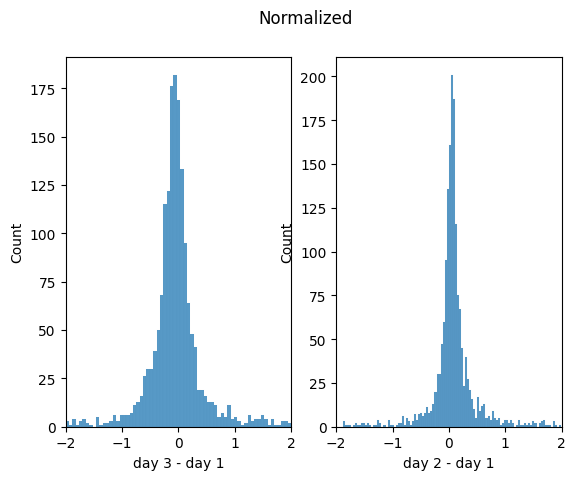

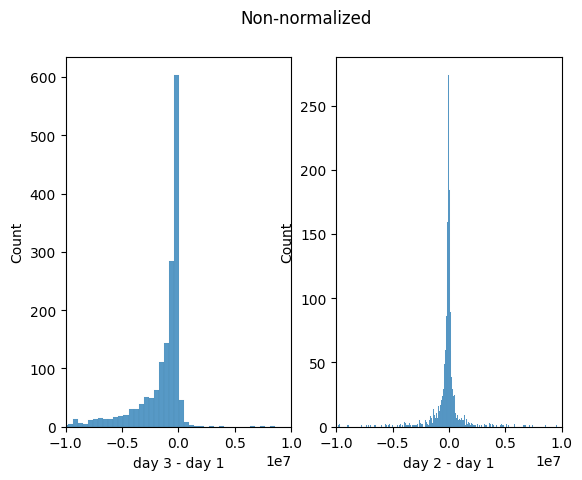

In [38]:
fig, ax = plot_distribution_of_differences(cntrl_pivot_by_measurement_norm, dif_to_plot, dif_labels)
ax_lim = 2
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]
fig.suptitle('Normalized')

ax_lim = 1e7
fig, ax = plot_distribution_of_differences(cntrl_pivot_by_measurement_nonnorm, dif_to_plot, dif_labels)
fig.suptitle('Non-normalized')
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]

#### Swarmplots for normalized values
These swarmplots compare the distribution of all proteins on each day before and after normalization. We can see that the normalization makes the difference in distributions much less. 



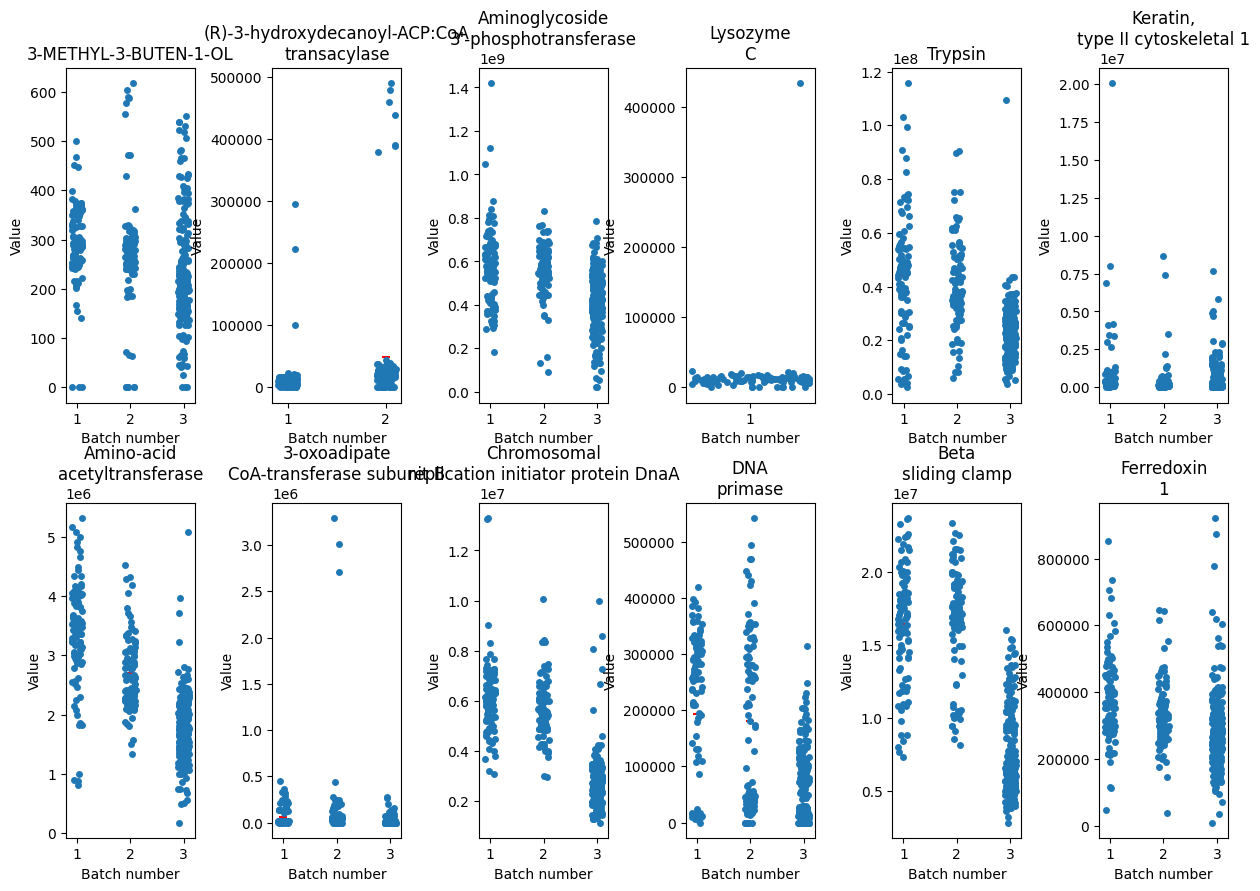

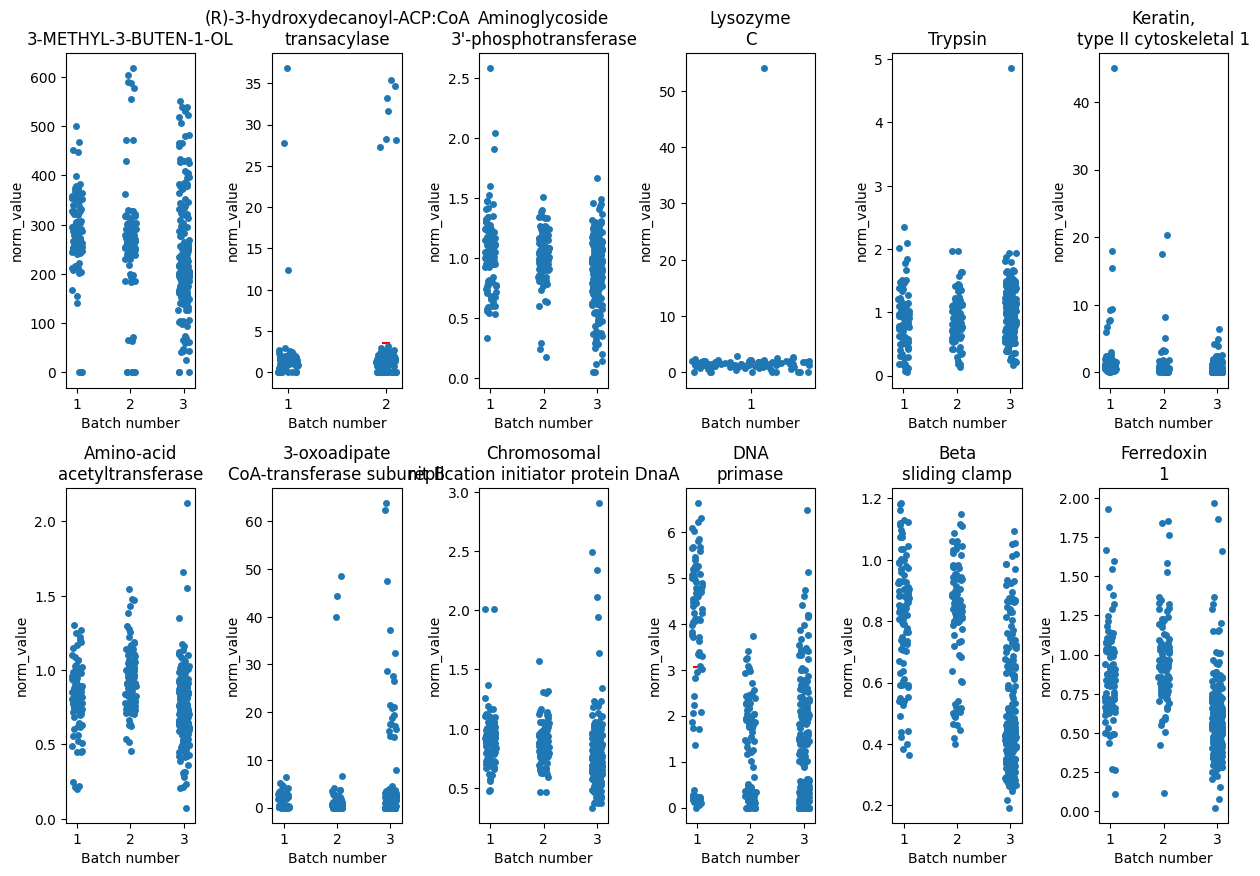

In [39]:
target_list_filter = df_norm['Measurement Type'].unique().tolist()

compare_swarm_multi(df_norm, target_list_filter[:12], [1,2,3], to_plot='Value')

compare_swarm_multi(df_norm, target_list_filter[:12], [1, 2, 3], to_plot='norm_value')


## Check the efficacy of CRISPRi - preprocessing
Now that we have normalized the data, we can proceed with Hector's filtering of the proteomics data in order to check how CRISPi performed. To do so, we will:
1. Get Strain Names
2. Get uniprot names for proteins ('Formal Type') column in dataframe
3. Map uniprot IDs to protein names using provided spreadsheet
4. Drop the rows that are not in targets from the proteomics protocol:
5. Change names from Uniprot to PP_ name
6. Add target gene

Define some useful functions.

Print some information from dataframes - unique line descriptors, names, formal types, and Protocols. Also, check negative values - there shouldn't be any in proteomics data.

In [40]:
unique_line_desc = df_norm['Line Description'].unique()
print('Line descriptions length and unique entries')
print(len(unique_line_desc))
print(unique_line_desc[:20])

print('Line names length and unique entries')
unique_line_name = df_norm['Line Name'].unique()
print(len(unique_line_name))
print(unique_line_name[:20])

print('Formal Types length and unique entries')
unique_formal_types = df_norm['Formal Type'].unique()
print(len(unique_formal_types))
print(unique_formal_types[:20])

print('Unique protocols')
print(df_norm['Protocol'].unique())

print(f'There are {len(df_norm[df_norm["Value"]<0])} negative values in df_norm')

Line descriptions length and unique entries
420
['BL1A2_IY1586' 'BL1A3_IY1587' 'BL1A4_IY1588' 'BL1A5_IY1589'
 'BL1A6_IY1590' 'BL1A7_IY1591' 'BL1A8_IY1592' 'BL1B2_IY1586'
 'BL1B3_IY1587' 'BL1B4_IY1588' 'BL1B5_IY1589' 'BL1B6_IY1590'
 'BL1B7_IY1591' 'BL1B8_IY1592' 'BL1C2_IY1586' 'BL1C3_IY1587'
 'BL1C4_IY1588' 'BL1C5_IY1589' 'BL1C6_IY1590' 'BL1C7_IY1591']
Line names length and unique entries
420
['PP_4549-R1' 'PP_4550-R1' 'PP_0368-R1' 'PP_2136-R1' 'PP_0774-R1'
 'PP_0362-R1' 'PP_0437-R1' 'PP_4549-R2' 'PP_4550-R2' 'PP_0368-R2'
 'PP_2136-R2' 'PP_0774-R2' 'PP_0362-R2' 'PP_0437-R2' 'PP_4549-R3'
 'PP_4550-R3' 'PP_0368-R3' 'PP_2136-R3' 'PP_0774-R3' 'PP_0362-R3']
Formal Types length and unique entries
2694
['cid:12988' 'sp|O85207|PHAG_PSEPK Phag' 'sp|P00552|KKA2_KLEPN Neo'
 'sp|P00698|LYSC_CHICK Lysozyme C' 'sp|P00761|TRYP_PIG Trypsin'
 'sp|P04264' 'sp|P0A0Z9|ARGA_PSEPK Arga' 'sp|P0A101|PCAJ_PSEPK Pcaj'
 'sp|P0A116|DNAA_PSEPK Dnaa' 'sp|P0A118|DNAG_PSEPK Dnag'
 'sp|P0A120|DPO3B_PSEPK Dnan' 'sp|P0A1

### 1. Add strain name to dataframe using prebuilt function.


In [66]:
df_norm["Strain"] = create_strain_names(df_norm)
print(df_norm.shape)

(971808, 12)


/tmp/ipykernel_1121819/3073247553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm["Strain"] = create_strain_names(df_norm)


### 2. Bring out Uniprot names

In [67]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)

get_uniprot_teststring = 'sp|Q9Z408|CSD_PSEPK Csda'

print(f'test string to extract uniprot: {get_uniprot_teststring} \nfunction output: {get_Uniprot(get_uniprot_teststring)}')

test string to extract uniprot: sp|Q9Z408|CSD_PSEPK Csda 
function output: Q9Z408


In [68]:
df_norm['Formal Type'] = df_norm['Formal Type'].apply(get_Uniprot)
df_norm.head()

/tmp/ipykernel_1121819/1443800260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm['Formal Type'] = df_norm['Formal Type'].apply(get_Uniprot)


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value,Strain
149646,Control-R1,BL1A1_NT,Global Proteomics,P00552,Aminoglycoside 3'-phosphotransferase,5.341811e+08,True,1,1,5.492638e+08,0.972540,NT
149647,Control-R2,BL1B1_NT,Global Proteomics,P00552,Aminoglycoside 3'-phosphotransferase,6.467078e+08,True,1,1,5.492638e+08,1.177408,NT
149648,Control-R3,BL1C1_NT,Global Proteomics,P00552,Aminoglycoside 3'-phosphotransferase,6.684408e+08,True,1,1,5.492638e+08,1.216976,NT
149649,Control-R4,BL2A1_NT,Global Proteomics,P00552,Aminoglycoside 3'-phosphotransferase,4.428832e+08,True,1,1,5.492638e+08,0.806321,NT
149650,Control-R5,BL2B1_NT,Global Proteomics,P00552,Aminoglycoside 3'-phosphotransferase,5.232355e+08,True,1,1,5.492638e+08,0.952612,NT


In [70]:
print(df_norm.shape)

(971808, 12)


### 3. Limit protein data to target genes. 
Since we only need the proteomics data for the target genes, we will only keep that. To figure out the target genes, we need to get the file mapping Uniprot IDs to PPxx names for the target genes:

In [71]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])
ProtMapping_df.head()

,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607_NT2,Q88MG4
1,IY1452_pIY1080,PP_1607_NT3,Q88MG4
2,IY1452_pIY1081,PP_1607_NT4_R1,Q88MG4
3,IY1452b_pIY1081,PP_1607_NT4_R2,Q88MG4
4,IY1452c_pIY1081,PP_1607_NT4_R3,Q88MG4


We will limit CRISPRi target gene name to standard names (e.g. we will convert 'PP_1607_NT2' to 'PP_1607')

In [72]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])

#### Protein-gene mapping sanity checks.
Need to check two things about protein-gene mapping:

- Are all of the target proteins still in the dataframe? Some could have been dropped if they could not be normalized.
- Is there a 1 to 1 correspondence between target genes and uniprot IDs?

First check if we dropped any target proteins.

In [73]:
#Create dataframe from full data and transform 'Formal Type' to get targets from full dataset
df2['Formal Type'] = df2['Formal Type'].apply(get_Uniprot)

targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()
targets_in_df_norm = df_norm['Formal Type'].unique().tolist()
targets_in_df_full = df2['Formal Type'].unique().tolist()
print(f'There are {len(targets_in_mapping)} unique targets in xlsx file\n' 
        f'{len(targets_in_df_norm)} unique targets in norm dataframe\n'
        f'{len(targets_in_df_full)} unique targets in full dataframe')

targets_not_in_df_norm = [ii for ii in targets_in_mapping if ii not in targets_in_df_norm]
print(f'Targets in mapping that have been dropped from df_norm: \n {targets_not_in_df_norm}')

targets_not_in_df_full = [ii for ii in targets_in_mapping if ii not in targets_in_mapping in targets_in_df_full]
print(f'There are {len(targets_not_in_df_full)} targets in map that are not in full dataframe')

There are 122 unique targets in xlsx file
2415 unique targets in norm dataframe
2696 unique targets in full dataframe
Targets in mapping that have been dropped from df_norm: 
 ['Q88QX2', 'Q88JR0', 'Q88GH9', 'Q88HG4', 'Q88HK1', 'Q88HS1', 'Q88N22', 'Q88HS3', 'Q88DT2', 'Q88QE6', 'P0A103', 'Q88PP2', 'Q88FG8', 'Q88FP6', 'Q88RM6', 'Q88RM5', 'Q88RM4', 'Q88RM3', 'Q88PN5', 'Q88PN4', 'Q88FD7', 'A0A140FWL1', 'Q88FD8', 'Q88R57', 'Q88E18', 'Q88RA8']
There are 0 targets in map that are not in full dataframe


Next check if there's a 1 to 1 correspondence in mapping. There should be several targets and genes that have multiple entries due to trying multiple guide RNAs/constructs, but the number of duplicate target genes and duplicate UNIPROT IDs should match and have the same number of duplicates. Note also that according to uniprot, UPID Q877U6 is associated with genes PP1157 and PP3365. https://www.uniprot.org/uniprotkb/Q877U6/entry

In [74]:
number_crispr_target_genes = len(ProtMapping_df["CRISPRi target gene"].unique())
number_uniprot_id = len(ProtMapping_df["UNIPROT ID"].unique())
target_value_counts = ProtMapping_df["CRISPRi target gene"].value_counts()
upid_value_counts = ProtMapping_df['UNIPROT ID'].value_counts()

print(f'In the Protein Mapping spreadsheet, there are {number_crispr_target_genes} unique target genes and {number_uniprot_id} unique uniprot IDs')
print('These targets have show up multiple times in the list:')
print(target_value_counts[target_value_counts>1])
print('These Uniprot IDs show up multiple times')
print(upid_value_counts[upid_value_counts>1])


In the Protein Mapping spreadsheet, there are 123 unique target genes and 122 unique uniprot IDs
These targets have show up multiple times in the list:
PP_1607    10
PP_0528     3
PP_0548     3
PP_4679     3
PP_4194     2
Name: CRISPRi target gene, dtype: int64
These Uniprot IDs show up multiple times
Q88MG4    10
Q88DY9     3
Q88QG6     3
Q88QE6     3
Q88FA4     2
Q877U6     2
Name: UNIPROT ID, dtype: int64


### 4. Drop the rows that are not in targets from Proteomics protocol:

In [75]:
df_norm = df_norm.drop(
                    index=df_norm[(~df_norm['Formal Type'].isin(targets_in_mapping)) &
                                  (df_norm['Protocol']=='Global Proteomics')].index)
print(df_norm.shape)


(40320, 12)


### 5. Change names from Uniprot to PP_ names
Create a protein mapping dictionary that translates from Uniprot to PP names:

In [76]:
protein_map = {}
for index in ProtMapping_df.index:
    protein_map[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]

Do the translation:

In [77]:
proteomics_ind = df_norm['Protocol']=='Global Proteomics'
df_norm.loc[proteomics_ind,'Formal Type'] = df_norm.loc[proteomics_ind,'Formal Type'].apply(lambda x: protein_map[x])

### 6. Add Target Gene
Add column with a target gene for each strain.

In [78]:
get_target_gene = lambda x: re.split('-', x)[0][0:7] # last part eliminates non standard names from PP name (e.g. PP_1607_NT3)
get_target_gene_teststring = 'PP_4549-R1'
print(f'To get target gene:\n Input string: {get_target_gene_teststring}, output: {get_target_gene(get_target_gene_teststring)}')

To get target gene:
 Input string: PP_4549-R1, output: PP_4549


In [79]:
df_norm['Target'] = df_norm['Line Name'].apply(get_target_gene)
df_norm.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value,Strain,Target
150702,Control-R1,BL1A1_NT,Global Proteomics,PP_2471,Integration host factor subunit alpha,4201002.90,True,1,1,4.103880e+06,1.023666,NT,Control
150703,Control-R2,BL1B1_NT,Global Proteomics,PP_2471,Integration host factor subunit alpha,4517773.00,True,1,1,4.103880e+06,1.100854,NT,Control
150704,Control-R3,BL1C1_NT,Global Proteomics,PP_2471,Integration host factor subunit alpha,3999560.28,True,1,1,4.103880e+06,0.974580,NT,Control
150705,Control-R4,BL2A1_NT,Global Proteomics,PP_2471,Integration host factor subunit alpha,3858903.76,True,1,1,4.103880e+06,0.940306,NT,Control
150706,Control-R5,BL2B1_NT,Global Proteomics,PP_2471,Integration host factor subunit alpha,3800910.30,True,1,1,4.103880e+06,0.926175,NT,Control


## Statistical Analysis
### Pivot dataframe to table:

Pivot dataframe to table with strain as the row name, columns as the gene, and proteomics values as the value. Create one for normalized values and one for non-normalized values.

In [80]:
df_targets_norm = df_norm.pivot_table(
    index = "Strain", columns = ["Formal Type"], values = "norm_value", aggfunc = np.mean)

df_targets = df_norm.pivot_table(
    index = "Strain", columns = ["Formal Type"], values = "Value", aggfunc = np.mean)

In [89]:
df_targets_norm.loc['NT',:].unique()

non_normed_targets = df_targets_norm.loc[:, df_targets_norm.loc['NT', :] != 1.].columns
non_normed_targets


Index(['PP_0368', 'PP_0597', 'PP_0944', 'PP_1755', 'PP_2112', 'PP_3122',
       'PP_3123', 'PP_3365', 'PP_4011', 'PP_4012', 'PP_4122', 'PP_4187',
       'PP_4194', 'PP_4549', 'PP_4550', 'PP_4636', 'PP_4667'],
      dtype='object', name='Formal Type')

look for these targets in dataframe

In [163]:
df_norm[(df_norm['Formal Type'] == non_normed_targets[0]) & (df_norm['Control'])]

for ii in range(1, 4):
    print(f'mean from dataframe: {np.mean(df_norm[(df_norm["Formal Type"] == non_normed_targets[0]) & (df_norm["Control"]) & (df_norm["Batch number"] == ii)]["Value"])}')
    print(f'Norm value from dataframe:\n{df_norm[(df_norm["Formal Type"] == non_normed_targets[0]) & (df_norm["Control"]) & (df_norm["Batch number"] == ii)]["control_val"]}')

#How does this mean get put into dataframe?
value_to_look_for = df_norm[(df_norm["Formal Type"] == non_normed_targets[0]) & (df_norm["Control"]) & (df_norm["Batch number"] == 1)]["control_val"].values[0]
value_to_look_for
loc_in_pivot = np.where(cntrl_pivot_by_measurement_exist == value_to_look_for)
found_index = cntrl_pivot_by_measurement_exist.index[loc_in_pivot[0]]
print(f'Found index: {found_index}')
df2[(df2['Measurement Type'] == found_index[0]) & (df2['Control'])]

# cntrl_pivot_by_measurement_exist_dropped = cntrl_pivot_by_measurement_exist.drop(not np.any(cntrl_pivot_by_measurement_exist == value_to_look_for))

mean from dataframe: 8611829.867142858
Norm value from dataframe:
369870    2.189836e+06
369871    2.189836e+06
369872    2.189836e+06
369873    2.189836e+06
369874    2.189836e+06
369875    2.189836e+06
369876    2.189836e+06
Name: control_val, dtype: float64
mean from dataframe: 7304181.168571429
Norm value from dataframe:
595182    3.680141e+06
595183    3.680141e+06
595184    3.680141e+06
595185    3.680141e+06
595186    3.680141e+06
595187    3.680141e+06
595188    3.680141e+06
Name: control_val, dtype: float64
mean from dataframe: 5788476.8675
Norm value from dataframe:
1143054    1.958974e+06
1143055    1.958974e+06
1143056    1.958974e+06
1143057    1.958974e+06
Name: control_val, dtype: float64
Found index: Index(['Putative Acyl-CoA dehydrogenase'], dtype='object', name='Measurement Type')


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number
193806,Control-R1,BL1A1_NT,Global Proteomics,Q88DP4,Putative Acyl-CoA dehydrogenase,36203.70,True,1
193807,Control-R2,BL1B1_NT,Global Proteomics,Q88DP4,Putative Acyl-CoA dehydrogenase,0.00,True,1
193808,Control-R3,BL1C1_NT,Global Proteomics,Q88DP4,Putative Acyl-CoA dehydrogenase,18366.21,True,1
193809,Control-R4,BL2A1_NT,Global Proteomics,Q88DP4,Putative Acyl-CoA dehydrogenase,29508.57,True,1
193810,Control-R5,BL2B1_NT,Global Proteomics,Q88DP4,Putative Acyl-CoA dehydrogenase,35002.20,True,1
193811,Control-R6,BL2C1_NT,Global Proteomics,Q88DP4,Putative Acyl-CoA dehydrogenase,22523.34,True,1
193812,Control-R7,BL3A1_NT,Global Proteomics,Q88DP4,Putative Acyl-CoA dehydrogenase,27112.02,True,1
237102,Control-R1,BL1A1_NT,Global Proteomics,Q88GT0,Putative Acyl-CoA dehydrogenase,164698.20,True,1
237103,Control-R2,BL1B1_NT,Global Proteomics,Q88GT0,Putative Acyl-CoA dehydrogenase,91879.40,True,1
237104,Control-R3,BL1C1_NT,Global Proteomics,Q88GT0,Putative Acyl-CoA dehydrogenase,232918.58,True,1


We can see that there are some Measurement types with multiple formal types
Check if the mean for this example of all the batch 1 measurements matches the mean that ended up in df_norm

In [167]:
value_from_df2 = df2[(df2['Measurement Type'] == found_index[0]) & (df2['Control']) & (df2['Batch number'] == 1)]['Value'].mean()
value_from_pivot = cntrl_pivot_by_measurement_exist[1][found_index[0]]
value_from_df2-value_from_pivot
                                                

0.0